** Importing the libraries required to process the data

In [167]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow import keras
from keras.layers.attention.multi_head_attention import activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix,RocCurveDisplay,ConfusionMatrixDisplay
from keras.layers import serialization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#!pip install keras-tuner
import kerastuner as kt
%matplotlib inline
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import hyperparameters

**Loading the dataset and adding the column names**

In [ ]:
db = pd.read_csv('pima-indians-diabetes.csv',header=None)
db.columns = ["No of times Preg","Plasma glucose concentration","Diastolic BP","Triceps SF thickness","serum insulin","BMI","Diab Ped Fun","age","diabetes"]
db.head(5)

,No of times Preg,Plasma glucose concentration,Diastolic BP,Triceps SF thickness,serum insulin,BMI,Diab Ped Fun,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Finding the null values in the given dataset**


In [ ]:
db.isna().sum()

No of times Preg                0
Plasma glucose concentration    0
Diastolic BP                    0
Triceps SF thickness            0
serum insulin                   0
BMI                             0
Diab Ped Fun                    0
age                             0
diabetes                        0
dtype: int64

**Checking the outliers in the dataset**


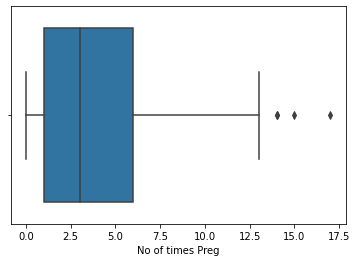

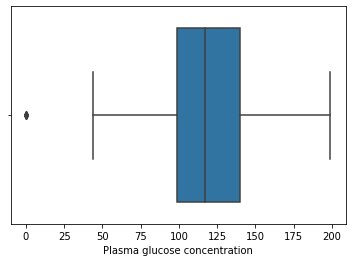

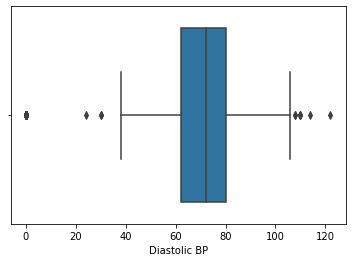

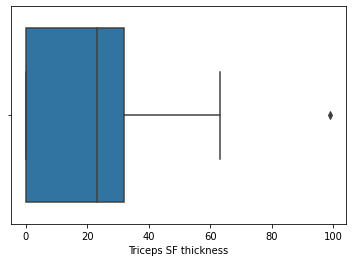

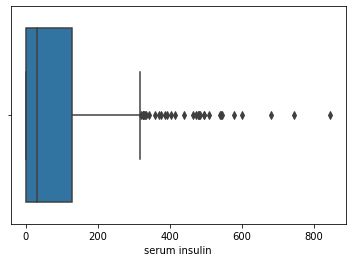

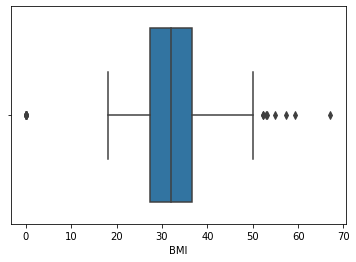

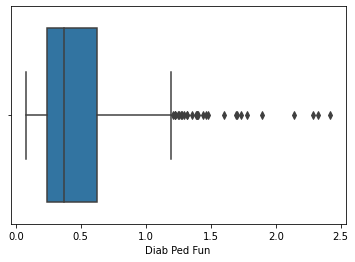

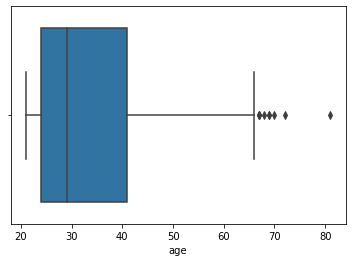

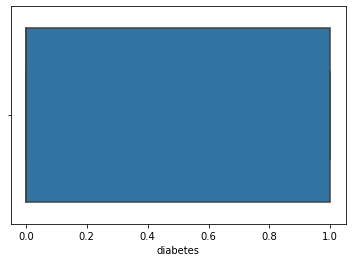

In [ ]:
#using seaborn boxplot to find the outliers
for j in db.columns:
    #ax = sns.boxplot(db[j])
    #print(db.columns[j])
    sns.boxplot(x=db[j])
    plt.xlabel(j)
    plt.show()
        

**Describing the dataset to find the statistical values.**

In [ ]:
db.describe()

,No of times Preg,Plasma glucose concentration,Diastolic BP,Triceps SF thickness,serum insulin,BMI,Diab Ped Fun,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Analyzing the dataset using sweetviz library*

In [ ]:
#Using sv.analyze to analyze dataset
result = sv.analyze(db)
#saving the analysis report as a html file
result.show_html('./report.html')

In [ ]:
#From the dataset we can see that diabetes is a label (as it is a predicting value)
label = 'diabetes'
features = [i for i in db.columns if i!='diabetes']

**Normalising the dataset using sklearn minmaxscaler*

In [ ]:
k = MinMaxScaler()
k.fit(db)
normalised_df= k.transform(db)
normalised_df = pd.DataFrame(normalised_df,columns=db.columns)
normalised_df.head()

,No of times Preg,Plasma glucose concentration,Diastolic BP,Triceps SF thickness,serum insulin,BMI,Diab Ped Fun,age,diabetes
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0.0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1.0


**Splitting data into two sets as train and test set using train_test_split module. 75% data for training and 25% data for testing*

In [ ]:
x_train,X_test,y_train,Y_test = train_test_split(normalised_df[features],normalised_df[label],test_size=0.25,shuffle=10)

## **Slicing the training and testing dataset using tensor.data.Dataset.from_tensor.slices()**

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(42)
test_set = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).shuffle(42)

### **Defining a function to fit the model and plotting the confusion matrix, ROC Curve, Accuracy vs Epoch and Loss vs Epoch**

In [176]:
#activation functions, optimization algorithms, batch sizes, number of epochs
def train_test_model(model_name, model_epochs, model_batch):
  # clear the previous session
  #keras.backend.clear_session()
  
  # fit the model
  model_fit = model_name.fit(train_set.batch(model_batch),
                             epochs=model_epochs,
                             validation_data = test_set.batch(model_batch),
                             shuffle=True,
                             verbose=False)
  
  # evaluate the model on the train and test sets
  _,train_accuracy, _ = model_name.evaluate(train_set.batch(20), verbose=False)
  _,test_accuracy, _ = model_name.evaluate(test_set.batch(20), verbose=False)
  print("Test Accuracy: ", test_accuracy)
  
  # make predictions on the test set
  y_pred = model_name.predict(test_set.batch(model_batch))
  y_pred = [int(np.round(x,0)) for x in y_pred]
  
  # plot the confusion matrix
  conf_matrix = confusion_matrix(Y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
  #matrix_names = ['True Neagtive', 'False Positive', 'False Negative', 'True Positive']
  #counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
  #labels = [f"{a1}\n{a2}" for a1, a2 in zip(matrix_names, counts)]
  #labels = np.asarray(labels).reshape(2,2)
  #sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='crest')
  cm_display.plot()
  plt.show()
  
  # plot the ROC curve
  RocCurveDisplay.from_predictions(Y_test,y_pred)
  print("Reciever Operating Characteristic curve\n")
  plt.show()
  
  # plot accuracy vs epoch
  plt.plot(model_fit.history['accuracy'])
  plt.plot(model_fit.history['val_accuracy'])
  plt.legend(['train', 'test'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  print("Epoch Vs Accuracy\n")
  plt.show()
  
  # plot loss vs epoch
  plt.plot(model_fit.history['loss'])
  plt.plot(model_fit.history['val_loss'])
  plt.legend(['train', 'test'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  print("Epoch Vs Loss\n")
  plt.show()
  keras.backend.clear_session()

### Defining the base model with one hidden layer of 12 units, activations relu and sigmoid. Compiled with loss function binarycrossentropy, optimizer - RMSprop with learning rate 0.001 and metrics accuracy,AUC

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None
Test Accuracy:  0.59375
2/2 [==============================] - 0s 5ms/step


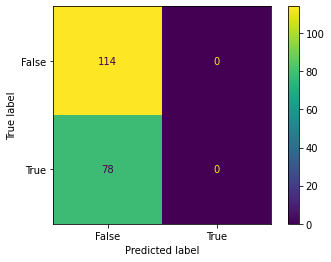

Reciever Operating Characteristic curve



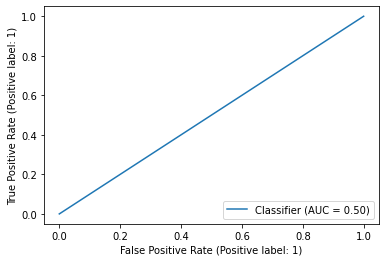

Epoch Vs Accuracy



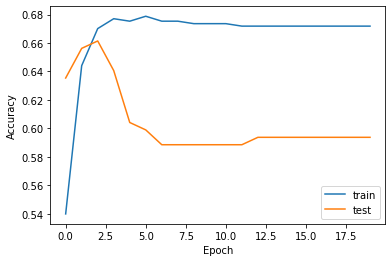

Epoch Vs Loss



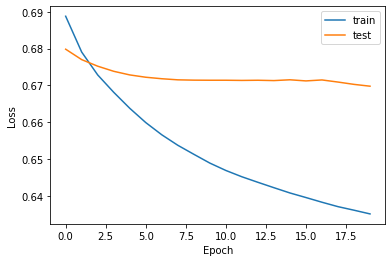

In [177]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12,input_dim=8,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
             metrics=['accuracy','AUC'])
print(base_model.summary())
train_test_model(base_model,20,128)

### Defining the second model with four layers with relu activation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 dense_2 (Dense)             (None, 500)               100500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 23)                11523     
                                                                 
 dense_4 (Dense)             (None, 1)                 24        
                                                                 
Total params: 122,697
Trainable params: 122,697
Non-trai

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


None
Test Accuracy:  0.7135416865348816
2/2 [==============================] - 0s 7ms/step


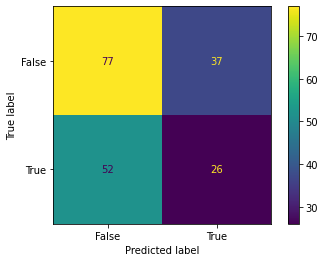

Reciever Operating Characteristic curve



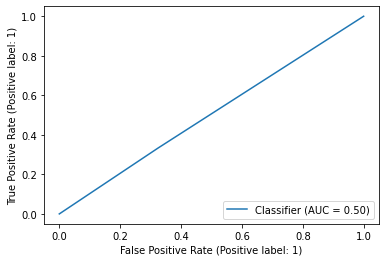

Epoch Vs Accuracy



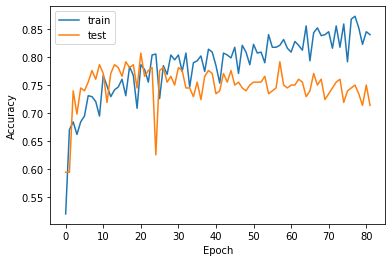

Epoch Vs Loss



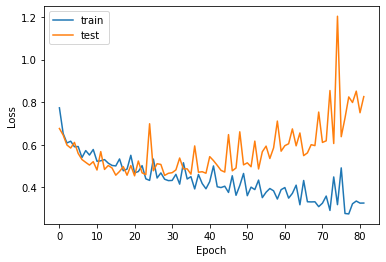

In [178]:
keras.backend.clear_session()
model1= tf.keras.Sequential([
    tf.keras.layers.Dense(50,input_dim = 8,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Dense(23,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.RMSprop(lr=0.005),
             metrics=['accuracy','AUC'])
print(model1.summary())
train_test_model(model1,82,128)

### Defining the second model with four layers with relu activation and adam optimizer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 dense_2 (Dense)             (None, 500)               100500    
                                                                 
 dense_3 (Dense)             (None, 23)                11523     
                                                                 
 dropout (Dropout)           (None, 23)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 24        
                                                                 
Total params: 122,697
Trainable params: 122,697
Non-trai

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Test Accuracy:  0.7760416865348816
3/3 [==============================] - 0s 5ms/step


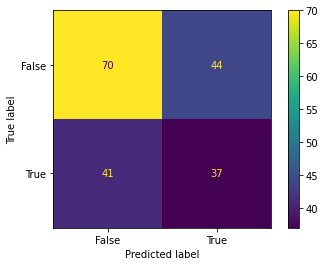

Reciever Operating Characteristic curve



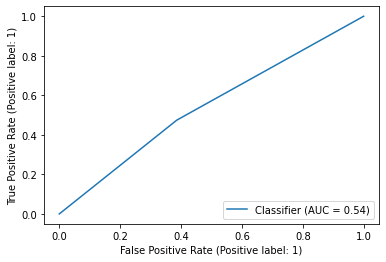

Epoch Vs Accuracy



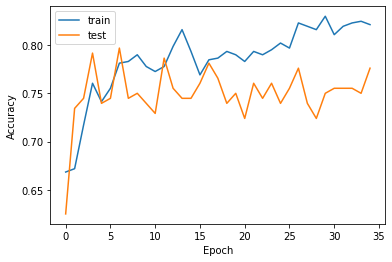

Epoch Vs Loss



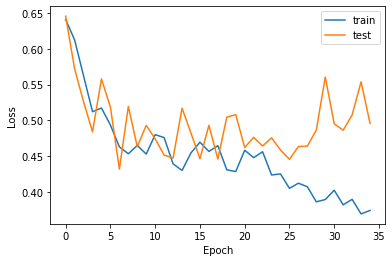

In [179]:
keras.backend.clear_session()
model2= tf.keras.Sequential([
    tf.keras.layers.Dense(50,input_dim = 8,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dense(23,activation='relu'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(lr=0.0077),
             metrics=['accuracy','AUC'])
print(model2.summary())
train_test_model(model2,35,80)

### Defining the second model with four layers with relu adagrad

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 200)               50200     
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 685,151
Trainable params: 685,151
Non-trainable params: 0
_________________________________________________________________
None
Test Accuracy:  0.7760416865348816
3/3 [=====

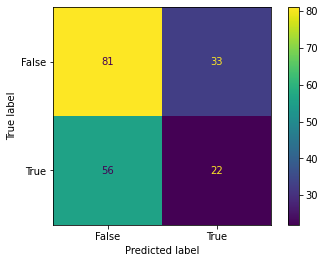

Reciever Operating Characteristic curve



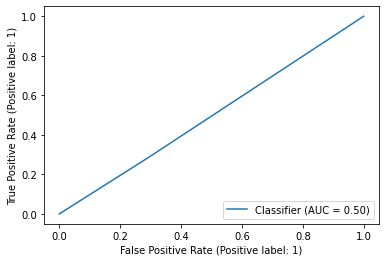

Epoch Vs Accuracy



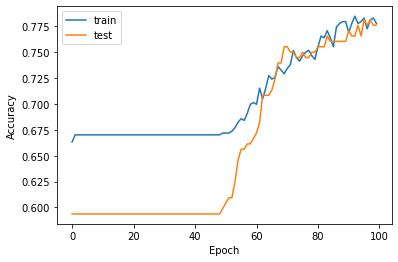

Epoch Vs Loss



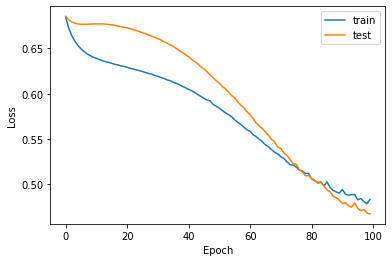

In [180]:
keras.backend.clear_session()
model3= tf.keras.Sequential([
    tf.keras.layers.Dense(1000,input_dim = 8,activation='relu'),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dense(250,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0088),
             metrics=['accuracy','AUC'])
print(model3.summary())
train_test_model(model3,100,64)

In [160]:
model3.save_weights('best_model_weights.txt')

Defining the second model with four layers with sigmoid and tanh activation, optimizer as RMSprop

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 200)               50200     
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 685,151
Trainable params: 685,151
Non-trainable params: 0
_________________________________________________________________
None
Test Accuracy:  0.59375
3/3 [================

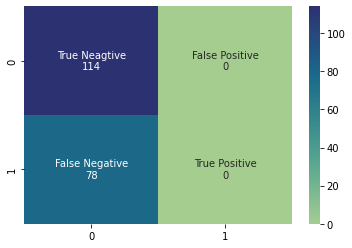

Reciever Operating Characteristic curve



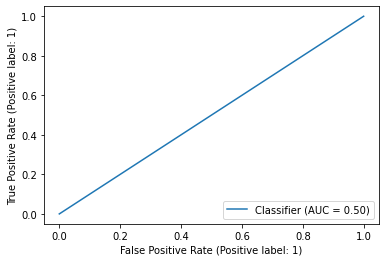

Epoch Vs Accuracy



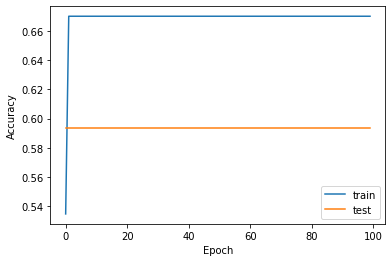

Epoch Vs Loss



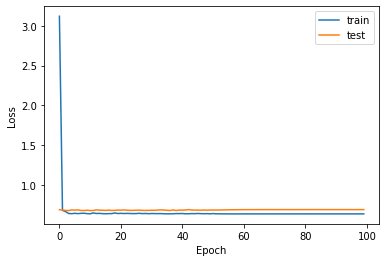

In [164]:
keras.backend.clear_session()
model4= tf.keras.Sequential([
    tf.keras.layers.Dense(1000,input_dim = 8,activation='sigmoid'),
    tf.keras.layers.Dense(500,activation='sigmoid'),
    tf.keras.layers.Dense(250,activation='tanh'),
    tf.keras.layers.Dense(200,activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0094),
             metrics=['accuracy','AUC'])
print(model4.summary())
train_test_model(model4,100,64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 dense_2 (Dense)             (None, 500)               100500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 23)                11523     
                                                                 
 dense_4 (Dense)             (None, 1)                 24        
                                                                 
Total params: 122,697
Trainable params: 122,697
Non-trai

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


None
Test Accuracy:  0.7760416865348816
2/2 [==============================] - 0s 7ms/step


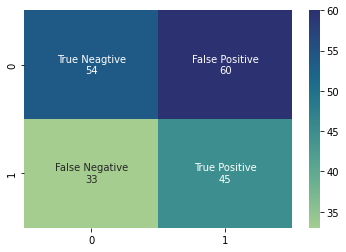

Reciever Operating Characteristic curve



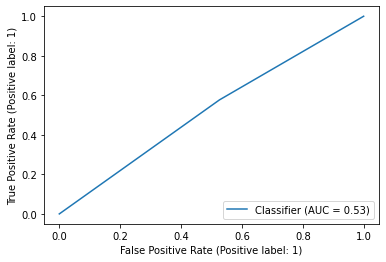

Epoch Vs Accuracy



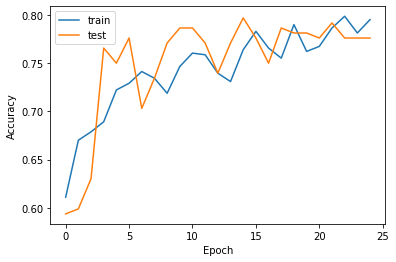

Epoch Vs Loss



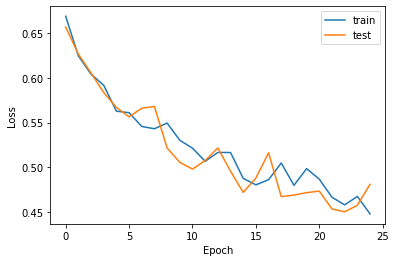

Epoch 1/2
5/5 [==============================] - 0s 15ms/step - loss: 0.5082 - accuracy: 0.7674 - auc: 0.7974 - val_loss: 0.4606 - val_accuracy: 0.7812 - val_auc: 0.8780
Epoch 2/2
5/5 [==============================] - 0s 13ms/step - loss: 0.4613 - accuracy: 0.7917 - auc: 0.8389 - val_loss: 0.4464 - val_accuracy: 0.7917 - val_auc: 0.8767


In [ ]:
keras.backend.clear_session()
model1= tf.keras.Sequential([
    tf.keras.layers.Dense(50,input_dim = 8,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Dense(23,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.RMSprop(lr=0.00128),
             metrics=['accuracy','AUC'])
print(model1.summary())
train_test_model(model1,25,128)
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='best_weights.h5',
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 save_weights_only=True)]

model1.fit(train_set.batch(128), epochs=2, callbacks=callbacks, validation_data=test_set.batch(128),verbose=True)

In [ ]:
keras.backend.clear_session()
model1= tf.keras.Sequential([
    tf.keras.layers.Dense(50,input_dim = 8,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Dense(23,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.RMSprop(lr=0.00128),
             metrics=['accuracy','AUC'])
print(model1.summary())
#train_test_model(model1,25,128)


#model1.fit(train_set.batch(128), epochs=2, callbacks=callbacks, validation_data=test_set.batch(128),verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 dense_2 (Dense)             (None, 500)               100500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 23)                11523     
                                                                 
 dense_4 (Dense)             (None, 1)                 24        
                                                                 
Total params: 122,697
Trainable params: 122,697
Non-trai

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Saving the model

In [119]:
model_checkpoint = ModelCheckpoint(filepath='best_model.h5',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   monitor='val_loss',
                                   mode='min',
                                   save_freq='epoch')

### Defining a function to find the best model using multiple values for input layers and different learning rates to find the best accuracy model

In [151]:
def model_builder(hp):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(hp.Int('units',min_value=8,max_value=2048,step=64),
                            activation='relu',
                            input_dim = 8
                                      ),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dense(1,activation='sigmoid')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning rate',[1e-2,1e-3,1e-4])),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy','AUC'])
  return model

**Keras Tuning, tuning the model using tuner and random search. Taking the best model using the get_best_hyperparqameters**

In [157]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_t',
                     project_name = 'keras_tuning')
stop_early =EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_set.batch(128), epochs=20, validation_data=test_set.batch(128), callbacks=[stop_early])
best_model=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 00m 02s]
val_accuracy: 0.59375

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 00m 54s


** Best model values**

In [158]:
best_model.values

{'units': 648,
 'learning rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}